In [289]:
import matplotlib.pyplot as plt
import seaborn as sbn
import happybase
import numpy as np
import random
import branca
import os 
import folium
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from folium import plugins

In [290]:
import findspark
findspark.add_jars("/usr/local/hbase/lib/hbase-client-2.3.5.jar")
findspark.init()

In [291]:
import sys
import logging
from pyspark.sql import SparkSession

# Logging configuration
formatter = logging.Formatter('[%(asctime)s] %(levelname)s @ line %(lineno)d: %(message)s')
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
handler.setFormatter(formatter)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(handler)


In [292]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("yarn")
    .appName("Hbase Spark")
    .getOrCreate()
)

In [293]:
import happybase

connection = happybase.Connection(host='localhost',
                                 )

wyswietlenie średniej dostępności rowerów dla stacji o danym ID, dane zagregowane do godzin
użytkownik może wyspecyfikować ile z ostatnich godzin chce wyświetlić, domyślnie 24

użyte i obliczone dane później przechowywane są w hdfsie

In [146]:
def wiz_1(station_id, connection, num_hours=24):
    
    
    batchview = connection.table('status_hourly')
    data = list(batchview.scan(filter="SingleColumnValueFilter ('id','station_id',=,'regexstring:^"+str(station_id)+"$')",columns=[b'id:station_id',b'metric:num_bikes_available']))
    
    values = []
    hours = []
    for v in data:
        values.append(float(v[1][b'metric:num_bikes_available']))
        hours.append(v[0].decode()[:13])
        
        
    values = values[-num_hours:]
    hours = hours[-num_hours:]
            

    fig = plt.figure(figsize = (16, 4.5))

    plt.bar(hours, values, color ='maroon', width = 0.85)

    plt.xlabel("Hour")
    plt.ylabel("No. of bikes available")
    plt.title("Average Bikes availability at every hour")
    plt.xticks(rotation=50)
    plt.show()
    
    df = pd.DataFrame(list(zip(values, hours)), columns =['No_of_bikes_available', 'Hour'])
    ts = str(time.time()).replace('.', '-')
    file_name = 'wiz_1_' + ts + '.parquet'
    df = spark.createDataFrame(df)
    df.write.save('/user/hive/analysis_data/'+file_name, format='parquet', mode='append') ## df is an existing DataFrame object.
    

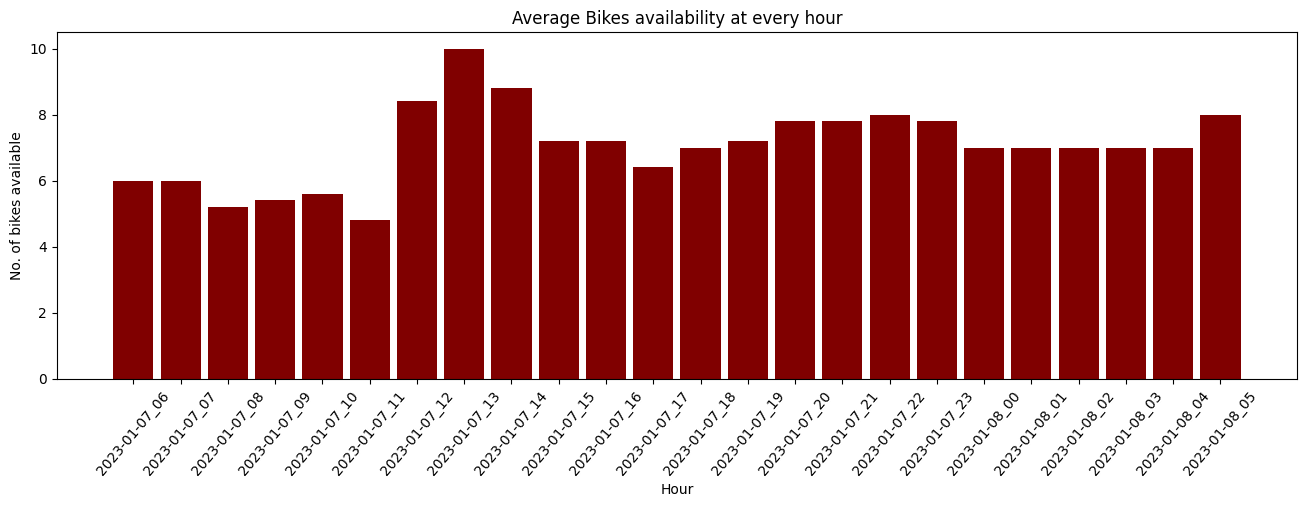

In [147]:
df = wiz_1(3995, connection)

In [ ]:

def wiz_2(station_id, day, connection):
    
    
    batchview = connection.table('status_hourly')
    
    # tu ewentualnie przefiltrowac po day, a jak nie to wywalic parametr day
    
    for key, data in batchview.scan(): # XD
        print(f'KEY: {key}')
        for column, value in data.items():
            print(f'\tCOLUMN: {column} VALUE: {value}')
            
    # zalozmy, ze jakos przygotowalismy dane do postaci
    # hours = [0, 1, 2, 3, ... (jesli to obecny dzien, to do godizny, do ktorej sa dane)]
    # values = [liczba_dost_roweruw_dla_tej_stacji w danej godzinie]
    # len(hours) == len(values)
    # przyklad wykresa komurka wyzej

    fig = plt.figure(figsize = (16, 4.5))

    plt.bar(hours, values, color ='maroon', width = 0.85)

    plt.xlabel("Hour")
    plt.ylabel("No. of bikes available")
    plt.title("Bikes availability at the start of every hour")
    plt.show()
    
    

Mapa, obrazująca zajętość danej stacji, uwzględniając jej położenie. Wyświetlane są także informacje pogodowe. Kolor jest uzależniony od stosunku dostępnych rowerów na stacji i jej pojemności. 

Obrazowane dane dotyczące stacji pokazywane są na batchu live.

In [148]:
def calculate_color(num_bikes_available, num_docks_available):
    percentage = num_bikes_available / (max(num_bikes_available + num_docks_available, 1))
    if percentage < 0.25:
        return 'red'
    elif percentage < 0.5:
        return 'yellow'
    else:
        return 'green'

In [149]:
def define_html(temp_m, precip_m, wind_m):
    
    legend_html = '''
    {% macro html(this, kwargs) %}
    <div style="
        position: fixed; 
        top: 10px;
        right: 10px;
        width: 170px;
        height: 60px;
        z-index:9999;
        font-size:14px;
        ">
        <p>&emsp;Temperature: '''
    legend_html += temp_m.decode() + ' <span>&#8451;</span><br>&emsp;Precipitation: ' + precip_m.decode() +\
        ' mm<br>&emsp;Wind Speed: ' + wind_m.decode() + ' km/h</p>'
    legend_html += '''
    </div>
    <div style="
        position: fixed; 
        top: 10px;
        right: 10px;
        width: 170px;
        height: 60px; 
        z-index:9998;
        font-size:14px;
        background-color: #ffffff;

        opacity: 0.7;
        ">
    </div>
    {% endmacro %}
    '''
    legend = branca.element.MacroElement()
    legend._template = branca.element.Template(legend_html)
    
    return legend

In [150]:
def map_wiz(connection):
    statusview = connection.table('status_live')
    weatherview = connection.table('weather_hourly')
    infoview = connection.table('information_daily')
    
    status = list(statusview.scan( columns=[b'id:station_id' ,b'metric:num_bikes_available', b'metric:num_docks_available']))
    info = list(infoview.scan(row_start=b'2023-01-08_116', columns=[b'id:station_id', b'geo:lat',b'geo:lon']))
    weather = list(weatherview.scan(columns=[b'precipitation:precipitation', b'temperature:temperature_2m',b'wind:windspeed_10m']))    
    
    info_df = pd.DataFrame(columns=[b'id:station_id', b'geo:lat',b'geo:lon'])
    status_df = pd.DataFrame(columns=[b'id:station_id',b'metric:num_bikes_available', b'metric:num_docks_available'])
    
    for i in info:
        info_df = info_df.append(pd.DataFrame([[i[1][b'id:station_id'], i[1][b'geo:lat'], i[1][b'geo:lon']]], columns=[b'id:station_id', b'geo:lat',b'geo:lon']), ignore_index=True)
    
    for s in status:
        status_df = status_df.append(pd.DataFrame([[s[1][b'id:station_id'], s[1][b'metric:num_bikes_available'], s[1][b'metric:num_docks_available']]], columns=[b'id:station_id', b'metric:num_bikes_available', b'metric:num_docks_available']), ignore_index=True)
    
    data = status_df.merge(info_df, on=b'id:station_id')
    
    temp_m = weather[-1][1][b'temperature:temperature_2m']
    wind_m = weather[-1][1][b'wind:windspeed_10m']
    precip_m = weather[-1][1][b'precipitation:precipitation']
    
    legened = define_html(temp_m, precip_m, wind_m)
    
    
    m = folium.Map(location=[40.730610, -73.935242])

    # trzeba polaczyc station statuses (num_bikes_available) z station information (lat, lon)

    for _, station in data.iterrows():
        if station[b'geo:lat'].decode() == 'None' or station[b'geo:lon'].decode() == 'None':
            continue
        location = [float(station[b'geo:lat'].decode()), float(station[b'geo:lon'].decode())]
        bikes_available = float(station[b'metric:num_bikes_available'].decode())
        docks_available = float(station[b'metric:num_docks_available'].decode())
        popup = "Bikes available: " + str(bikes_available) + "\nDocks available: " + str(docks_available)
        color = calculate_color(bikes_available, docks_available)

        folium.Circle(
            location=location,
            radius=15,
            popup=popup,
            color=color,
            fill=True,
            fill_opacity=0.5,
            fill_color=color,
        ).add_to(m)

    m.get_root().add_child(legend)


    ts = str(time.time()).replace('.', '-')
    file_name = 'wiz_map_' + ts + '.parquet'
    df = spark.createDataFrame(data)
    df.write.save('/user/hive/analysis_data/'+file_name, format='parquet', mode='append') ## df is an existing DataFrame object.
    
    
    return m

In [151]:
m = map_wiz(connection)

In [152]:
m

Pokazanie regionów w celu przeanalizowania później, jak rentowne jest funkcjonowanie danej dzielnicy. Dopasowanie kierunku rozwoju i ekspansji floty rowerowej. Wyjaśnienie różnic w rentowności, jeśli by zaistniały.

In [ ]:
"cyan", "brown", "magenta"

In [184]:
def calculate_color_region(region_id):
    region_id = int(region_id.decode())
    
    if region_id == 311:
        return "orange"
    elif region_id == 70:
        return "brown"
    elif region_id == 71:
        return "blue"
    else:
        return 'black'

In [185]:
def show_regions(connection):
    statusview = connection.table('status_live')
    weatherview = connection.table('weather_hourly')
    infoview = connection.table('information_daily')
    
    status = list(statusview.scan( columns=[b'id:station_id' ,b'metric:num_bikes_available', b'metric:num_docks_available']))
    info = list(infoview.scan(row_start=b'2023-01-08_116', columns=[b'id:station_id', b'geo:lat',b'geo:lon', b'id:region_id']))
    weather = list(weatherview.scan(columns=[b'precipitation:precipitation', b'temperature:temperature_2m',b'wind:windspeed_10m']))        
    
    info_df = pd.DataFrame(columns=[b'id:station_id', b'geo:lat',b'geo:lon', b'id:region_id'])
    status_df = pd.DataFrame(columns=[b'id:station_id',b'metric:num_bikes_available', b'metric:num_docks_available'])
    
    for i in info:
        info_df = info_df.append(pd.DataFrame([[i[1][b'id:station_id'], i[1][b'geo:lat'], i[1][b'geo:lon'], i[1][b'id:region_id']]], columns=[b'id:station_id', b'geo:lat',b'geo:lon', b'id:region_id']), ignore_index=True)
    
    
    for s in status:
        status_df = status_df.append(pd.DataFrame([[s[1][b'id:station_id'], s[1][b'metric:num_bikes_available'], s[1][b'metric:num_docks_available']]], columns=[b'id:station_id', b'metric:num_bikes_available', b'metric:num_docks_available']), ignore_index=True)
    
    
    data = status_df.merge(info_df, on=b'id:station_id')
    
    temp_m = weather[-1][1][b'temperature:temperature_2m']
    wind_m = weather[-1][1][b'wind:windspeed_10m']
    precip_m = weather[-1][1][b'precipitation:precipitation']
    
    legened = define_html(temp_m, precip_m, wind_m)
    
    
    m = folium.Map(location=[40.730610, -73.935242])


    for _, station in data.iterrows():
        if station[b'geo:lat'].decode() == 'None' or station[b'geo:lon'].decode() == 'None':
            continue
        location = [float(station[b'geo:lat'].decode()), float(station[b'geo:lon'].decode())]
        bikes_available = float(station[b'metric:num_bikes_available'].decode())
        docks_available = float(station[b'metric:num_docks_available'].decode())
        popup = "Region: " + str(station[b'id:region_id'].decode())
        color = calculate_color_region(station[b'id:region_id'])

        folium.Circle(
            location=location,
            radius=15,
            popup=popup,
            color=color,
            fill=True,
            fill_opacity=0.5,
            fill_color=color,
        ).add_to(m)

    m.get_root().add_child(legend)


    ts = str(time.time()).replace('.', '-')
    file_name = 'regions_map_' + ts + '.parquet'
    df = spark.createDataFrame(data)
    df.write.save('/user/hive/analysis_data/'+file_name, format='parquet', mode='append') ## df is an existing DataFrame object.
    
    
    return m

In [186]:
m = show_regions(connection)

In [187]:
m

In [233]:
def num_rentals_wiz(connection):
    statusview = connection.table('status_live')
    infoview = connection.table('information_daily')

    status = list(statusview.scan( columns=[b'id:station_id', b'metric:num_docks_available']))
    info = list(infoview.scan(row_start=b'2023-01-08_116', columns=[b'id:station_id', b'id:region_id']))


    info_df = pd.DataFrame(columns=[b'id:station_id', b'id:region_id'])
    status_df = pd.DataFrame(columns=[b'id:station_id', b'metric:num_docks_available'])

    for i in info:
        info_df = info_df.append(pd.DataFrame([[i[1][b'id:station_id'], i[1][b'id:region_id']]], columns=[b'id:station_id', b'id:region_id']), ignore_index=True)


    for s in status:
        status_df = status_df.append(pd.DataFrame([[s[1][b'id:station_id'], s[1][b'metric:num_docks_available']]], columns=[b'id:station_id', b'metric:num_docks_available']), ignore_index=True)


    data = status_df.merge(info_df, on=b'id:station_id')    
    
    for d in data.iterrows():
        if d[1][b'id:region_id'] == b'71':
            b71.append(int(d[1][b'metric:num_docks_available']))

        if d[1][b'id:region_id'] == b'70':
            b70.append(int(d[1][b'metric:num_docks_available']))

        if d[1][b'id:region_id'] == b'311':
            b311.append(int(d[1][b'metric:num_docks_available']))
        
    regions_id = ['Manhattan', 'Jersey City', 'Hoboken']
    values = [np.mean(np.asarray(b71)), np.mean(np.asarray(b70)), np.mean(np.asarray(b311))]

    fig = plt.figure(figsize = (16, 4.5))

    plt.bar(regions_id, values, color ='maroon', width = 0.85)

    plt.xlabel("Region")
    plt.ylabel("Average docks available")
    plt.title("Average docks available per region")
    plt.show()
    
    ts = str(time.time()).replace('.', '-')
    file_name = 'regions_avail_' + ts + '.parquet'
    df = spark.createDataFrame(data)
    df.write.save('/user/hive/analysis_data/'+file_name, format='parquet', mode='append') ## df is an existing DataFrame object.
    
   

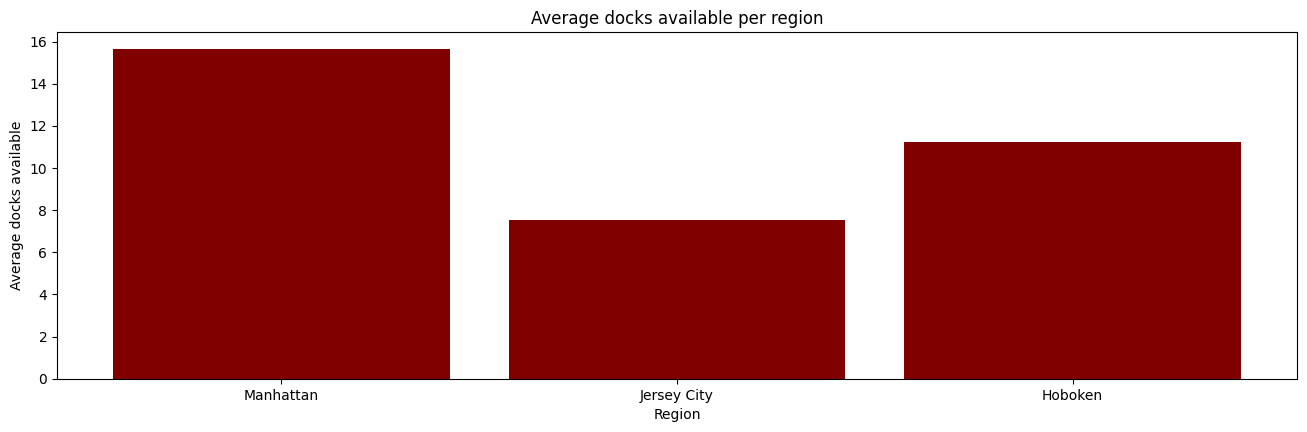

In [234]:
num_rentals_wiz(connection)

In [294]:
def plot_weather(connection, name = b'temperature:apparent_temperature', num_hours = 24):


    batchview = connection.table('weather_hourly')
    data = list(batchview.scan(columns=[ name]))

    values = []
    hours = []
    for v in data:
        values.append(float(v[1][name]))
        hours.append(v[0].decode()[:13])


    values = values[-num_hours:]
    hours = hours[-num_hours:]

    fig = plt.figure(figsize = (16, 4.5))

    # creating the bar plot
    plt.plot(hours, values, color ='maroon')

    plt.xlabel("Hour")
    name = name.decode().split(':')[1]
    plt.ylabel(name)
    plt.title(name + " in New York")
    plt.xticks(rotation=50)
    plt.show()
    
    df = pd.DataFrame(list(zip(values, hours)), columns =[name, 'Hour'])
    ts = str(time.time()).replace('.', '-')
    file_name = 'wiz_weather_' + ts + '.parquet'
    df = spark.createDataFrame(df)
    df.write.save('/user/hive/analysis_data/'+file_name, format='parquet', mode='append') ## df is an existing DataFrame object.
    

[2023-01-09 09:23:14,197] INFO @ line 234: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-01-09 09:23:14,197] INFO @ line 234: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-01-09 09:23:14,197] INFO @ line 234: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-01-09 09:23:14,197] INFO @ line 234: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-01-09 09:23:14,197] INFO @ line 234: Using categorical units t

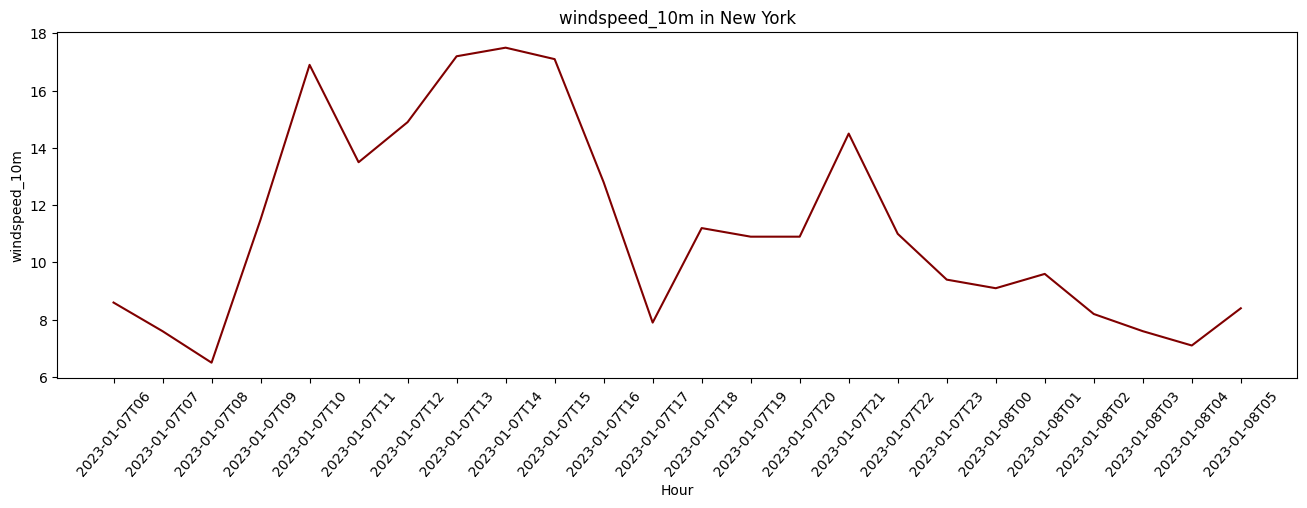

In [296]:
plot_weather(connection, name = b'wind:windspeed_10m')

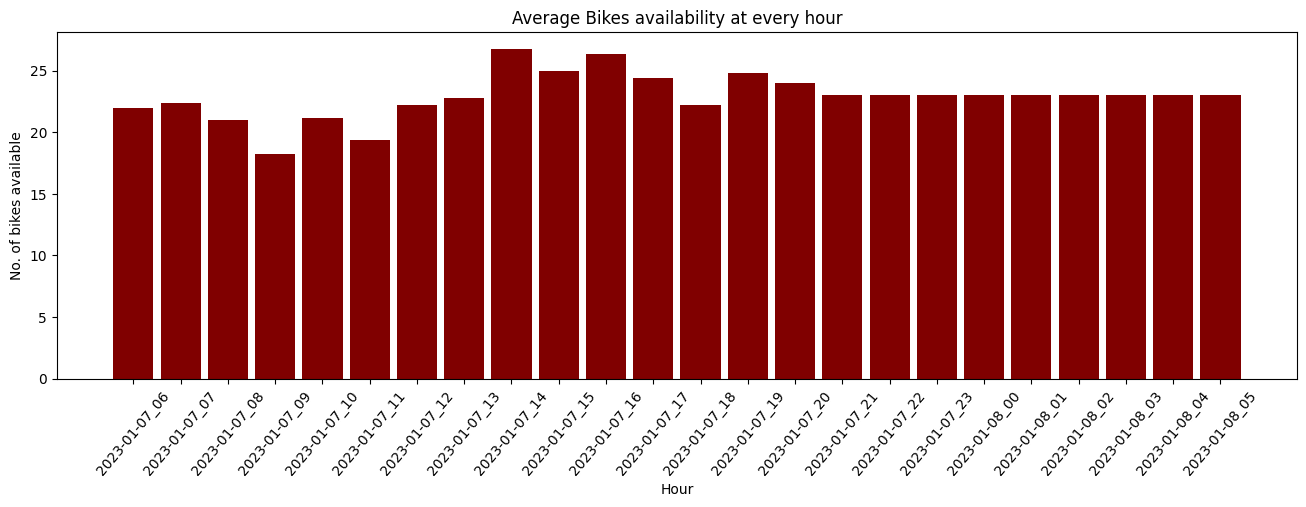

In [287]:
df = wiz_1(195, connection)